# Лабораторная 1
### Белова Полина, Фролова Юлия

### POS - tagger (German)

### Типология языков

## Немецкий
Язык флективного (или флективно-аналитического) строя, синтетический тип
### Генеалогическая классификация:
- Индоевропейские языки
- Германская ветвь
- Западногерманская группа
- Верхненемецкие языки
Порядок слов в предложении фиксирован. В утвердительном предложении подлежащее на первом месте, сказуемое всегда на втором. 

In [1]:
from conllu import parse_incr
import numpy as np
import pandas as pd
import string

Функция считывает файлы и создает список списков токенов(all_sent) и список соответствующих им тегов (all_tag)
- тег ['form'] это конкретная словоформа, ['upostag'] соответствующий этой словоформе тег

In [2]:
def read_and_enjoy(filename):
    all_sent = []
    all_tag =[]
    data = open(filename, 'r', encoding='utf-8')
    for sentences in parse_incr(data): #парсим корпусы
        new_tag = []
        sent=[]
        for word in sentences:
            sent.append(word['form'].lower()) #список слов в одном предложении
            new_tag.append(word['upostag']) #список соответствующих им тегов
        all_sent.append(sent) #список списков всех слов
        all_tag.append(new_tag) #список списков всех тегов
    return all_sent, all_tag

In [4]:
ger_train_sents, ger_train_tags = read_and_enjoy("de_gsd-ud-train.conllu")
ger_test_sents, ger_test_tags = read_and_enjoy("de_gsd-ud-test.conllu")

In [5]:
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Функция для сбора статистики
- word_freqs - это словарь всех токенов с частотой их встречаемости
- maxlen - максимальная длина предложения в корпусе
- minlen - минимальная длина предложения в корпусе
- num_sent - количество предложений в корпусе
- median - медиана числа слов в предложении
- mean - математическое ожидание
- tags_freqs - словарь всех тегов с их частотностью
- wordtags - просто словарик слов и соответствующих им тегов (на всякий случай)

In [6]:
import collections
def parse_sentences(corpus, corpus1):
    word_freqs = collections.Counter() 
    tags_freqs = collections.Counter() 
    num_sent, maxlen = 0, 0
    wordtags = {}
    lengths = []
    tags = {}
    minlen = 50
    median, mean = 0, 0
    for line in range(len(corpus)):
        for i in range(len(corpus[line])):
            word_freqs[corpus[line][i]] += 1 #собираем все токены с их частотностью
            tags_freqs[corpus1[line][i]] +=1 #все теги с их частотностью
            wordtags[corpus[line][i]] = corpus1[line][i] #словарь токенов и соответствующих им тегов
        if len(corpus[line]) > maxlen:
            maxlen = len(corpus[line]) #вычисляем максимальную длину предложения
        if len(corpus[line]) < minlen:
            minlen = len(corpus[line]) #вычисляем минимальную длину предложения
        lengths.append(len(corpus[line])) #собираем длины всех предложений в список для вычисления медианы и мат ожидания
        num_sent +=1 #вычисляем кол-во предложения
    
    median = np.median(np.array(lengths)) #медиана
    mean = np.mean(np.array(lengths)) #мат ожидание
    return word_freqs, maxlen, minlen, num_sent, median, mean, tags_freqs, wordtags
ger_freqs, ger_max, ger_min, ger_num, ger_median, ger_mean, ger_tags, ger_wordtags = parse_sentences(ger_train_sents, ger_train_tags)
ger_test_freqs, ger_test_max, ger_test_min, ger_test_num, ger_test_median, ger_test_mean, ger_t_tags, ger_test_wordtags = parse_sentences(ger_test_sents, ger_test_tags)

функция вычисления доли новых слов в тестовом корпусе

In [7]:
def new_words(corpus, freqs, freqs1):
    all_words = collections.Counter(freqs + freqs1) # объединяем все слова 
    dolya = round(1 - len(freqs)/len(all_words), 6) # делим кол-во всех знакомых слов на кол-во всех слов и вычитаем из 1
    return dolya, all_words
ger_dolya, ger_all = new_words(ger_test_sents, ger_freqs, ger_test_freqs)

In [8]:
print ('Число предложений: %d\nЧисло уникальных словоформ: %d\nЧисло уникальных PoS-тегов: %d\nМакс слов:%d\nМин слов:%d\nМат ожидание:%f\nМедиана:%f\nДоля новых слов:%f' % (ger_num, len(ger_freqs), len(ger_tags), ger_max, ger_min, ger_mean, ger_median, ger_dolya))

Число предложений: 13814
Число уникальных словоформ: 47758
Число уникальных PoS-тегов: 17
Макс слов:117
Мин слов:2
Мат ожидание:19.430578
Медиана:17.000000
Доля новых слов:0.033767


### Гистограмма тегов тренировочного корпуса

<Container object of 17 artists>

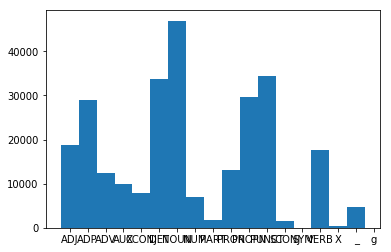

In [9]:
dictionary = dict(ger_tags)
plt.bar(list(dictionary.keys()), dictionary.values(), 'g', align='center')

### Гистограмма тегов тестового корпуса

<Container object of 16 artists>

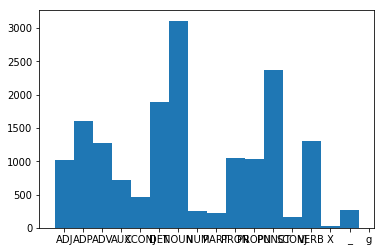

In [10]:
dictionary = dict(ger_t_tags)
plt.bar(list(dictionary.keys()), dictionary.values(), 'g', align='center')

- за максимальную длину предложения мы взяли значение, чуть большее медианы
- решили взять не все токены (надо же все-таки щадить ноутбуки), поэтому взяли 30000 самых встречающихся токенов (потом мы с этим еще поиграемся)

In [11]:
MAX_SEQLEN = 20
S_MAX_FEATURES = 30000
T_MAX_FEATURES = 17

In [12]:
NUM_EPOCHS = 8

кодируем слова и теги уникальным числом, а также добавляем в словари слово для паддингов и незнакомых токенов

In [13]:
ger_word2index = {w[0]: i + 2 for i,w in enumerate(ger_freqs.most_common(S_MAX_FEATURES))}
ger_word2index['PAD'] = 0
ger_word2index['UNK'] = 1
ger_tag2index = {t: i + 1 for i,t in enumerate(ger_tags)}
ger_tag2index['PAD'] = 0

In [14]:
S_MAX_FEATURES += 2 # добавляем к длине токенов 2 (паддинг и незнакомый токен)
T_MAX_FEATURES += 1 # добавляем к длине тегов 1 (паддинг)

In [15]:
def build_tensor(sents, numsents, toindex, maxlen):
    data = np.empty((numsents, ), dtype=list)
    i = 0
    for line in sents:
        wids = []
        for word in line:
            if word in toindex:
                wids.append(toindex[word]) # список индексов слов в предложении
            else:
                wids.append(toindex['UNK']) # если не знаем, то записываем индекс 1 (незнакомое слово)
        data[i] = wids
        i += 1
    pdata = sequence.pad_sequences(data, maxlen=maxlen, padding='post', truncating="post") # добавляем паддинги до MAX_SEQLEN
    return pdata
X = build_tensor(ger_train_sents, ger_num, ger_word2index, MAX_SEQLEN)
Xtest = build_tensor(ger_test_sents, ger_test_num, ger_word2index, MAX_SEQLEN)
Y = build_tensor(ger_train_tags, ger_num, ger_tag2index, MAX_SEQLEN)
Ytest = build_tensor(ger_test_tags, ger_test_num, ger_tag2index, MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42) # из тренировочную корпуса берем часть на валидацию

### SimpleRNN

во всех моделях 
- batch_size=64
- hidden_layer=64
- размеры эмбеддингов для моделей: 64, 100, 200
- activation - softmax, loss - categorical_crossentropy, потому что это задача классификации
- оптимизатор adam, т.к. с ним еще не работали, но он в принципе похож на rmsprop

In [16]:
from keras.layers import SimpleRNN

In [17]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 64)            1920128   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 64)            8256      
_________________________________________________________________
dense_1 (Dense)              (None, 20, 18)            1170      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 18)            0         
Total params: 1,929,554
Trainable params: 1,929,554
Non-trainable params: 0
_________________________________________________________________


функция, которая оценивает работу модели без паддингов

In [18]:
# y - correct answers - tags
# h - predictions
def evaluate(y, h, test_tags):
    new_y = []
    new_h = []
    for line in y:
        k = 0
        for i in range(len(test_tags[k])):
            new_y.append(line[i])
        k+=1
    for line in h:
        k = 0
        for i in range(len(test_tags[k])):
            new_h.append(line[i])
        k+=1
    
        
    classes = set(new_y)
    len_new_y = len(new_y)

    results = {'accuracy w/o paddings': 0}
    class_dist = {c: new_y.count(c) / len_new_y for c in classes}

    for c in classes:
        tp = set()
        fp = set()
        tn = set()
        fn = set()

        for i, h_i in enumerate(new_h):
            y_i = new_y[i]
            if h_i == y_i:
                if h_i == c:
                    tp.add((i, h_i))
                else:
                    tn.add((i, h_i))
        acc = len(tp | tn) / len(new_h) # так как мы в метриках оценивания используем только точность, то и здесь подсчитаем только ее

        results['accuracy w/o paddings']  += acc * class_dist[c]
    return results

In [ ]:
import os
os.makedirs('cu\\rnn_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\rnn_model\\cu-easy_model-history.json')

сохраняем веса для каждой эпохи, что потом по эпохе до переобучения сделать предсказания и посчитать точность модели без паддингов

In [19]:
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 9s 800us/step - loss: 1.7359 - acc: 0.5143 - val_loss: 0.8899 - val_acc: 0.7280

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051 [==============================] - 7s 597us/step - loss: 0.6321 - acc: 0.8164 - val_loss: 0.4171 - val_acc: 0.8778

Epoch 00002: saving model to cu\rnn_model\cu-easy_model-2.h5
Epoch 3/8
11051/11051 [==============================] - 7s 672us/step - loss: 0.3147 - acc: 0.9124 - val_loss: 0.2917 - val_acc: 0.9084

Epoch 00003: saving model to cu\rnn_model\cu-easy_model-3.h5
Epoch 4/8
11051/11051 [==============================] - 8s 760us/step - loss: 0.2079 - acc: 0.9386 - val_loss: 0.2704 - val_acc: 0.9106

Epoch 00004: saving model to cu\rnn_model\cu-easy_model-4.h5
Epoch 5/8
11051/11051 [==============================] - 8s 755us/step - loss: 0.1725 - acc: 0.9446 - val_loss: 0.2666 - val_acc: 0.9108

Epoch 00005: savi

переобучение на 7 эпохе, т.к. валидационная точность начинает давать сбои, потери растут. Модель начала переобучиваться раньше, чем на польском, возможно, потому что так сформировалась валидационная выборка, либо из-за того, что на немецком языке данных больше (соответственно и параметров в каждой модели)

In [20]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-6.h5')

In [21]:
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_rnn)

977/977 [==============================] - 0s 82us/step
0.9018935598394888
{'accuracy w/o paddings': 0.879136813374275}


строим графики

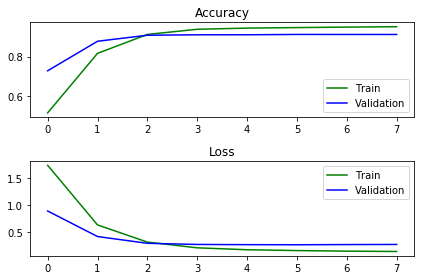

In [22]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [23]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           3000200   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 64)            10560     
_________________________________________________________________
dense_2 (Dense)              (None, 20, 18)            1170      
_________________________________________________________________
activation_2 (Activation)    (None, 20, 18)            0         
Total params: 3,011,930
Trainable params: 3,011,930
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 18s 2ms/step - loss: 1.6457 - acc: 0.5425 - val_loss: 0.8162 - val_acc: 0.7620

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11051/1

переобучение на 8 эпохе, т.к. валидационная точность начинает падать, а потери растут

In [24]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-7.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_rnn)

977/977 [==============================] - 0s 96us/step
0.9078300908863728
{'accuracy w/o paddings': 0.8851074718526101}


строим графики

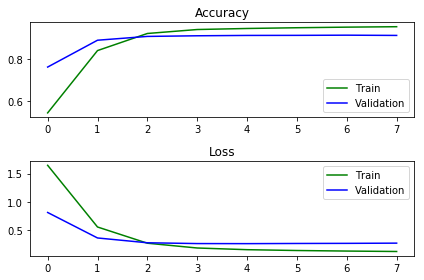

In [25]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [26]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 200)           6000400   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 20, 64)            16960     
_________________________________________________________________
dense_3 (Dense)              (None, 20, 18)            1170      
_________________________________________________________________
activation_3 (Activation)    (None, 20, 18)            0         
Total params: 6,018,530
Trainable params: 6,018,530
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 200)           6000400   
_________________________________________________________________


переобучение на 6 эпохе, т.к. валидационная точность начинает падать, а потери растут

In [28]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-4.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_rnn)

977/977 [==============================] - 0s 92us/step
0.9073695032232981
{'accuracy w/o paddings': 0.8853633572159674}


строим графики

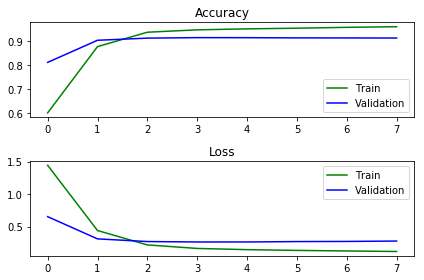

In [29]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| RNN | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | 7 | 0.9019 | 0.9124 | 0.2648 | 0.879136813374275 |
| **2 модель** | 100 | 8 | 0.9078 | 0.9147 | 0.2731 | 0.8851074718526101 |
| **3 модель** | 200 | 5 | 0.9073 | 0.9141 | 0.2646 | 0.8853633572159674 | 

пока гипотезы и заметки по работе моделей:
- чем больше размер эмбеддинга, тем, возможно, больше тестовая и валидационная точности и точность без паддингов, а также меньше потери, что логично, т.к. в модель поступает больше параметров
- лучшие данные у моделей с размером эмбеддингов в 100 и 200. Есть небольшая разница: например, в моделе с эмбеддингом 200 ненамного лучше точность предсканных тегов без паддингов, а также меньше валидационные потери. Данные по другим показателям отличается только тысячными. 
- В принципе модели с большим размером эмбеддинга показывают себя лучше

повторяем все то же самое для других сеток

### LSTM

In [30]:
from keras.layers.recurrent import LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 64)            1920128   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
dense_4 (Dense)              (None, 20, 18)            1170      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 18)            0         
Total params: 1,954,322
Trainable params: 1,954,322
Non-trainable params: 0
_________________________________________________________________


In [ ]:
os.makedirs('cu\\lstm_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\lstm_model\\cu-easy_model-history.json')

In [31]:
checkpoint = ModelCheckpoint('cu\\lstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 21s 2ms/step - loss: 1.9826 - acc: 0.4042 - val_loss: 1.2492 - val_acc: 0.6328

Epoch 00001: saving model to cu\lstm_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051 [==============================] - 10s 882us/step - loss: 0.8106 - acc: 0.7563 - val_loss: 0.5084 - val_acc: 0.8541

Epoch 00002: saving model to cu\lstm_model\cu-easy_model-2.h5
Epoch 3/8
11051/11051 [==============================] - 9s 844us/step - loss: 0.3624 - acc: 0.9034 - val_loss: 0.3205 - val_acc: 0.9029

Epoch 00003: saving model to cu\lstm_model\cu-easy_model-3.h5
Epoch 4/8
11051/11051 [==============================] - 9s 852us/step - loss: 0.2275 - acc: 0.9366 - val_loss: 0.2864 - val_acc: 0.9095

Epoch 00004: saving model to cu\lstm_model\cu-easy_model-4.h5
Epoch 5/8
11051/11051 [==============================] - 9s 850us/step - loss: 0.1837 - acc: 0.9442 - val_loss: 0.2749 - val_acc: 0.9113

Epoch 00005: 

переобучение на 7 эпохе, т.к. валидационная точность начинает давать сбои, потери растут

In [32]:
lstm_model.load_weights('cu\\lstm_model\\cu-easy_model-6.h5')
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_lstm)

977/977 [==============================] - 0s 157us/step
0.9004605963383873
{'accuracy w/o paddings': 0.8760661890139883}


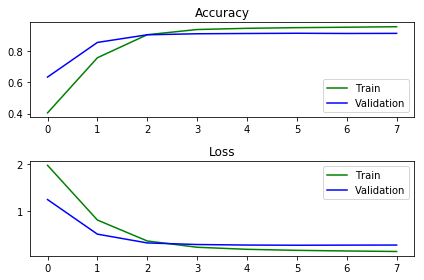

In [33]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(lstm_history.history["acc"], color="g", label="Train")
plt.plot(lstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(lstm_history.history["loss"], color="g", label="Train")
plt.plot(lstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [34]:
from keras.layers.recurrent import LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()
checkpoint = ModelCheckpoint('cu\\lstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 100)           3000200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 64)            42240     
_________________________________________________________________
dense_5 (Dense)              (None, 20, 18)            1170      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 18)            0         
Total params: 3,043,610
Trainable params: 3,043,610
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 34s 3ms/step - loss: 1.9031 - acc: 0.4401 - val_loss: 1.0356 - val_acc: 0.6811

Epoch 00001: saving model to cu\lstm_model\cu-easy_model-1.h5
Epoch 2/8
11051/

переобучение на 6 эпохе, т.к. валидационная точность начинает давать сбои, потери растут

In [35]:
lstm_model.load_weights('cu\\lstm_model\\cu-easy_model-5.h5')
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_lstm)

977/977 [==============================] - 0s 304us/step
0.901740013515937
{'accuracy w/o paddings': 0.8784544524053224}


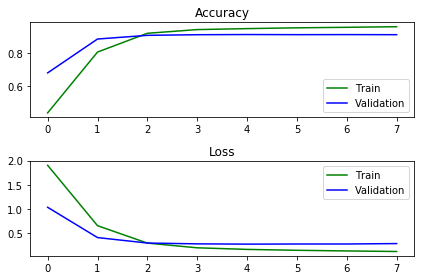

In [36]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(lstm_history.history["acc"], color="g", label="Train")
plt.plot(lstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(lstm_history.history["loss"], color="g", label="Train")
plt.plot(lstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [37]:
from keras.layers.recurrent import LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()
checkpoint = ModelCheckpoint('cu\\lstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 200)           6000400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 64)            67840     
_________________________________________________________________
dense_6 (Dense)              (None, 20, 18)            1170      
_________________________________________________________________
activation_6 (Activation)    (None, 20, 18)            0         
Total params: 6,069,410
Trainable params: 6,069,410
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 63s 6ms/step - loss: 1.6671 - acc: 0.5423 - val_loss: 0.7526 - val_acc: 0.7813

Epoch 00001: saving model to cu\lstm_model\cu-easy_model-1.h5
Epoch 2/8
11051/

переобучение на 6 эпохе, т.к. валидационная точность начинает давать сбои, потери растут

In [38]:
lstm_model.load_weights('cu\\lstm_model\\cu-easy_model-5.h5')
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_lstm)

977/977 [==============================] - 0s 324us/step
0.9009211967520973
{'accuracy w/o paddings': 0.876919140225179}


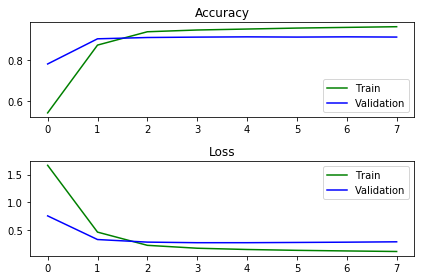

In [39]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(lstm_history.history["acc"], color="g", label="Train")
plt.plot(lstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(lstm_history.history["loss"], color="g", label="Train")
plt.plot(lstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| LSTM | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | 7 | 0.9005 | 0.9127 | 0.2711 | 0.8760661890139883 |
| **2 модель** | 100 | 6 | 0.9017 | 0.9120 | 0.2744 | 0.8784544524053224 |
| **3 модель** | 200 | 6 | 0.901 | 0.9138 | 0.2676 | 0.876919140225179 | 

заметки по работе моделей:
- чем больше размер эмбеддинга, тем быстрее модель переобучивается. Это связано с кол-вом параметров, которые в конечном счете подаются в модель
- разница показателях снова минимальная, однако, опять же рекомендуют себя лучше модели с размеров эмбеддингов в 100 и 200: у 100 лучше показатели по тестовойо точности и потерям, у 200 - по валидационной точности и точности без паддингов. 

### Bidirectional LSTM

In [40]:
from keras.layers.wrappers import Bidirectional
bilstm_model = Sequential()
bilstm_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 64)            1920128   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 128)           66048     
_________________________________________________________________
dense_7 (Dense)              (None, 20, 18)            2322      
_________________________________________________________________
activation_7 (Activation)    (None, 20, 18)            0         
Total params: 1,988,498
Trainable params: 1,988,498
Non-trainable params: 0
_________________________________________________________________


In [ ]:
os.makedirs('cu\\bilstm_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\bilstm_model\\cu-easy_model-history.json')

In [41]:
checkpoint = ModelCheckpoint('cu\\bilstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
bilstm_history = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 63s 6ms/step - loss: 1.8547 - acc: 0.4376 - val_loss: 1.0367 - val_acc: 0.6901

Epoch 00001: saving model to cu\bilstm_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051 [==============================] - 21s 2ms/step - loss: 0.6346 - acc: 0.8122 - val_loss: 0.3780 - val_acc: 0.8856

Epoch 00002: saving model to cu\bilstm_model\cu-easy_model-2.h5
Epoch 3/8
11051/11051 [==============================] - 20s 2ms/step - loss: 0.2619 - acc: 0.9253 - val_loss: 0.2642 - val_acc: 0.9165

Epoch 00003: saving model to cu\bilstm_model\cu-easy_model-3.h5
Epoch 4/8
11051/11051 [==============================] - 21s 2ms/step - loss: 0.1708 - acc: 0.9488 - val_loss: 0.2422 - val_acc: 0.9220

Epoch 00004: saving model to cu\bilstm_model\cu-easy_model-4.h5
Epoch 5/8
11051/11051 [==============================] - 20s 2ms/step - loss: 0.1393 - acc: 0.9560 - val_loss: 0.2375 - val_acc: 0.9230

Epoch 0000

переобучение на 7 эпохе, т.к. валидационная точность начинает давать сбои, потери растут

In [42]:
bilstm_model.load_weights('cu\\bilstm_model\\cu-easy_model-6.h5')
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_bilstm)

977/977 [==============================] - 0s 319us/step
0.9158137202140862
{'accuracy w/o paddings': 0.8964517229614464}


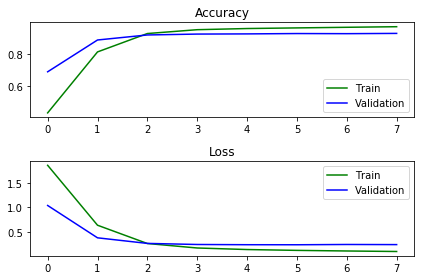

In [43]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(bilstm_history.history["acc"], color="g", label="Train")
plt.plot(bilstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(bilstm_history.history["loss"], color="g", label="Train")
plt.plot(bilstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [44]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()
checkpoint = ModelCheckpoint('cu\\bilstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
bilstm_history = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 100)           3000200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 128)           84480     
_________________________________________________________________
dense_8 (Dense)              (None, 20, 18)            2322      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 18)            0         
Total params: 3,087,002
Trainable params: 3,087,002
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 79s 7ms/step - loss: 1.7034 - acc: 0.5003 - val_loss: 0.7876 - val_acc: 0.7665

Epoch 00001: saving model to cu\bilstm_model\cu-easy_model-1.h5
Epoch 2/8
1105

переобучение на 7 эпохе, т.к. валидационная точность начинает давать сбои, потери растут

In [45]:
bilstm_model.load_weights('cu\\bilstm_model\\cu-easy_model-6.h5')
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_bilstm)

977/977 [==============================] - 1s 594us/step
0.9171954850335449
{'accuracy w/o paddings': 0.8978164448993519}


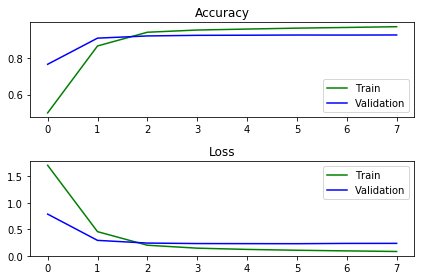

In [46]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(bilstm_history.history["acc"], color="g", label="Train")
plt.plot(bilstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(bilstm_history.history["loss"], color="g", label="Train")
plt.plot(bilstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [47]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 200)           6000400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 128)           135680    
_________________________________________________________________
dense_9 (Dense)              (None, 20, 18)            2322      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 18)            0         
Total params: 6,138,402
Trainable params: 6,138,402
Non-trainable params: 0
_________________________________________________________________


In [48]:
checkpoint = ModelCheckpoint('cu\\bilstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
bilstm_history = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 75s 7ms/step - loss: 1.4601 - acc: 0.5655 - val_loss: 0.5223 - val_acc: 0.8375

Epoch 00001: saving model to cu\bilstm_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051 [==============================] - 43s 4ms/step - loss: 0.3199 - acc: 0.9053 - val_loss: 0.2537 - val_acc: 0.9190

Epoch 00002: saving model to cu\bilstm_model\cu-easy_model-2.h5
Epoch 3/8
11051/11051 [==============================] - 43s 4ms/step - loss: 0.1637 - acc: 0.9505 - val_loss: 0.2323 - val_acc: 0.9251

Epoch 00003: saving model to cu\bilstm_model\cu-easy_model-3.h5
Epoch 4/8
11051/11051 [==============================] - 43s 4ms/step - loss: 0.1265 - acc: 0.9592 - val_loss: 0.2283 - val_acc: 0.9263

Epoch 00004: saving model to cu\bilstm_model\cu-easy_model-4.h5
Epoch 5/8
11051/11051 [==============================] - 46s 4ms/step - loss: 0.1071 - acc: 0.9650 - val_loss: 0.2296 - val_acc: 0.9273

Epoch 0000

переобучение, скорей всего, на 6 эпохе: валидационная точность хоть и растет, но, возможно, что на 6 эпохе дело лишь в тысячных + потери растут, начиная с пятой эпохи, но они более серьезные на 6

In [49]:
bilstm_model.load_weights('cu\\bilstm_model\\cu-easy_model-5.h5')
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_bilstm)

977/977 [==============================] - 1s 833us/step
0.9136130977555453
{'accuracy w/o paddings': 0.8935516888433982}


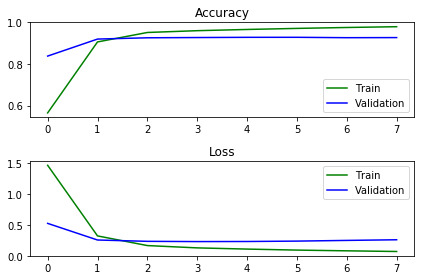

In [50]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(bilstm_history.history["acc"], color="g", label="Train")
plt.plot(bilstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(bilstm_history.history["loss"], color="g", label="Train")
plt.plot(bilstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| biLSTM | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | 7 | 0.9158 | 0.9252 | 0.2366 | 0.8964517229614464 |
| **2 модель** | 100 | 7 | 0.9172 | 0.9267 | 0.2322 | 0.8978164448993519 |
| **3 модель** | 200 | 6 | 0.9136 | 0.9273 | 0.2296 | 0.8935516888433982 | 

заметки по работе моделей:
- как было замечено выше при работе lstm, модель переобучивается раньше, если размер эмбеддинга, а вместе с ними кол-во параметров в модели больше. 
- опять за звание лучшей модели борются модели с эмбеддингами в 100 и 200: у 100 лучше тестовая точность и точность без паддингов, у 200 - потери и валидационная точность. Стоит заметить, что при размере эмбеддинга 64 точность без паддингов даже лучше той же точности у модели с эмбеддингом 200.
- Стоит предположить, что если бы модель с эмбеддингом 200 не переобучилась на 6 эпохе, тогда и ее показатели были бы лучше в конечном счете

### GRU

In [51]:
gru_model = Sequential()
gru_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 64)            1920128   
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 64)            24768     
_________________________________________________________________
dense_10 (Dense)             (None, 20, 18)            1170      
_________________________________________________________________
activation_10 (Activation)   (None, 20, 18)            0         
Total params: 1,946,066
Trainable params: 1,946,066
Non-trainable params: 0
_________________________________________________________________


In [ ]:
os.makedirs('cu\\gru_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\gru_model\\cu-easy_model-history.json')

In [52]:
checkpoint = ModelCheckpoint('cu\\gru_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
gru_history = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 41s 4ms/step - loss: 1.7271 - acc: 0.5072 - val_loss: 0.7975 - val_acc: 0.7649

Epoch 00001: saving model to cu\gru_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051 [==============================] - 20s 2ms/step - loss: 0.5294 - acc: 0.8488 - val_loss: 0.3646 - val_acc: 0.8933

Epoch 00002: saving model to cu\gru_model\cu-easy_model-2.h5
Epoch 3/8
11051/11051 [==============================] - 20s 2ms/step - loss: 0.2703 - acc: 0.9240 - val_loss: 0.2867 - val_acc: 0.9092

Epoch 00003: saving model to cu\gru_model\cu-easy_model-3.h5
Epoch 4/8
11051/11051 [==============================] - 20s 2ms/step - loss: 0.1945 - acc: 0.9410 - val_loss: 0.2732 - val_acc: 0.9108

Epoch 00004: saving model to cu\gru_model\cu-easy_model-4.h5
Epoch 5/8
11051/11051 [==============================] - 22s 2ms/step - loss: 0.1654 - acc: 0.9462 - val_loss: 0.2702 - val_acc: 0.9118

Epoch 00005: saving mo

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [53]:
gru_model.load_weights('cu\\gru_model\\cu-easy_model-8.h5')
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = gru_model.predict_classes(Xtest)
prediction_gru = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_gru)

977/977 [==============================] - 0s 447us/step
0.9046571139425436
{'accuracy w/o paddings': 0.8812691914022519}


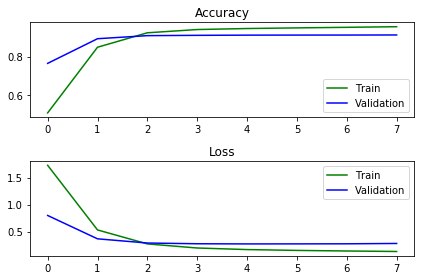

In [54]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(gru_history.history["acc"], color="g", label="Train")
plt.plot(gru_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(gru_history.history["loss"], color="g", label="Train")
plt.plot(gru_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [55]:
gru_model = Sequential()
gru_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()
checkpoint = ModelCheckpoint('cu\\gru_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
gru_history = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 100)           3000200   
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 64)            31680     
_________________________________________________________________
dense_11 (Dense)             (None, 20, 18)            1170      
_________________________________________________________________
activation_11 (Activation)   (None, 20, 18)            0         
Total params: 3,033,050
Trainable params: 3,033,050
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 57s 5ms/step - loss: 1.5684 - acc: 0.5639 - val_loss: 0.6545 - val_acc: 0.8142

Epoch 00001: saving model to cu\gru_model\cu-easy_model-1.h5
Epoch 2/8
11051/1

переобучение на 6 эпохе, т.к. валидационная точность начинает давать сбои (на 5 и 6 она одинаковая, но на 6 потери начинают резко расти)

In [56]:
gru_model.load_weights('cu\\gru_model\\cu-easy_model-5.h5')
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = gru_model.predict_classes(Xtest)
prediction_gru = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_gru)

977/977 [==============================] - 1s 752us/step
0.9049641823695407
{'accuracy w/o paddings': 0.8826339133401568}


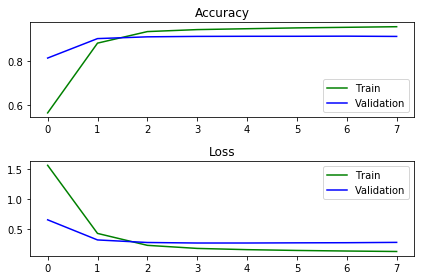

In [57]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(gru_history.history["acc"], color="g", label="Train")
plt.plot(gru_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(gru_history.history["loss"], color="g", label="Train")
plt.plot(gru_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [58]:
gru_model = Sequential()
gru_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()
checkpoint = ModelCheckpoint('cu\\gru_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
gru_history = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 20, 200)           6000400   
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 64)            50880     
_________________________________________________________________
dense_12 (Dense)             (None, 20, 18)            1170      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 18)            0         
Total params: 6,052,450
Trainable params: 6,052,450
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 120s 11ms/step - loss: 1.3019 - acc: 0.6652 - val_loss: 0.4743 - val_acc: 0.8617

Epoch 00001: saving model to cu\gru_model\cu-easy_model-1.h5
Epoch 2/8
11051

переобучение на 6 эпохе, т.к. валидационная точность начинает давать сбои, потери растут

In [59]:
gru_model.load_weights('cu\\gru_model\\cu-easy_model-5.h5')
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = gru_model.predict_classes(Xtest)
prediction_gru = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_gru)

977/977 [==============================] - 1s 831us/step
0.9043500463086482
{'accuracy w/o paddings': 0.8815250767656089}


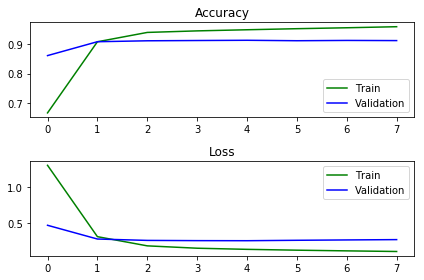

In [60]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(gru_history.history["acc"], color="g", label="Train")
plt.plot(gru_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(gru_history.history["loss"], color="g", label="Train")
plt.plot(gru_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| GRU | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | нет | 0.9047 | 0.9128 | 0.2786 | 0.8812691914022519 |
| **2 модель** | 100 | 6 | 0.9049 | 0.9135 | 0.2656 | 0.8826339133401568 |
| **3 модель** | 200 | 6 | 0.9044 | 0.9142 | 0.2615 | 0.881525076765089 | 

заметки по работе моделей:
- в gru модель переобучивается раньше с увеличением размера эмбеддинга (кол-во параметров модели)
- разница в показателях опять лишь в долях тысячных
- точность без паддингов и тестовая точность лучше у модели с размером эмбеддинга 100, валидационная точность и потери - у 200

В самом конце ноутбука будут приведены заметки по сравнению моделей с одним и тем же размером эмбеддинга

### Шоу эксперименты
Просто меняем размер S_MAX_FEATURES (только SimpleRNN). 

- Выбрали SimpleRNN, т.к. он быстрее остальных считается.
- Решили поиграть с размером S_MAX_FEATURES, чтобы посмотреть, насколько сильно меняется точность предсказаний без паддингов в зависимости от кол-ва токенов, которые подаются в модель
- Сравниваем модели при размере эмбеддинга 64

Берем только 5000 первых токенов.

In [61]:
MAX_SEQLEN = 20
S_MAX_FEATURES = 5000
T_MAX_FEATURES = 17

In [62]:
ger_word2index = {w[0]: i + 2 for i,w in enumerate(ger_freqs.most_common(S_MAX_FEATURES))}
ger_word2index['PAD'] = 0
ger_word2index['UNK'] = 1
ger_tag2index = {t: i + 1 for i,t in enumerate(ger_tags)}
ger_tag2index['PAD'] = 0

In [63]:
S_MAX_FEATURES += 2
T_MAX_FEATURES += 1

In [64]:
X = build_tensor(ger_train_sents, ger_num, ger_word2index, MAX_SEQLEN)
Xtest = build_tensor(ger_test_sents, ger_test_num, ger_word2index, MAX_SEQLEN)
Y = build_tensor(ger_train_tags, ger_num, ger_tag2index, MAX_SEQLEN)
Ytest = build_tensor(ger_test_tags, ger_test_num, ger_tag2index, MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [65]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 20, 64)            320128    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20, 64)            8256      
_________________________________________________________________
dense_13 (Dense)             (None, 20, 18)            1170      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 18)            0         
Total params: 329,554
Trainable params: 329,554
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 71s 6ms/step - loss: 1.6957 - acc: 0.5176 - val_loss: 0.8293 - val_acc: 0.7650

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [66]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-8.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_rnn)

977/977 [==============================] - 0s 504us/step
0.8866939567860708
{'accuracy w/o paddings': 0.8608836574547934}


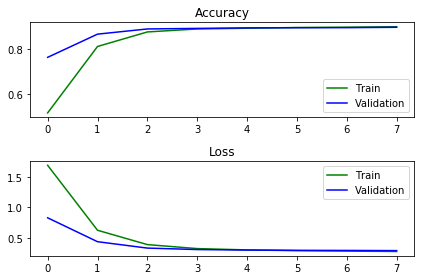

In [67]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Берем уже 15000 токенов

In [68]:
MAX_SEQLEN = 20
S_MAX_FEATURES = 15000
T_MAX_FEATURES = 17

In [69]:
ger_word2index = {w[0]: i + 2 for i,w in enumerate(ger_freqs.most_common(S_MAX_FEATURES))}
ger_word2index['PAD'] = 0
ger_word2index['UNK'] = 1
ger_tag2index = {t: i + 1 for i,t in enumerate(ger_tags)}
ger_tag2index['PAD'] = 0

In [70]:
S_MAX_FEATURES += 2
T_MAX_FEATURES += 1

In [71]:
X = build_tensor(ger_train_sents, ger_num, ger_word2index, MAX_SEQLEN)
Xtest = build_tensor(ger_test_sents, ger_test_num, ger_word2index, MAX_SEQLEN)
Y = build_tensor(ger_train_tags, ger_num, ger_tag2index, MAX_SEQLEN)
Ytest = build_tensor(ger_test_tags, ger_test_num, ger_tag2index, MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [72]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 20, 64)            960128    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20, 64)            8256      
_________________________________________________________________
dense_14 (Dense)             (None, 20, 18)            1170      
_________________________________________________________________
activation_14 (Activation)   (None, 20, 18)            0         
Total params: 969,554
Trainable params: 969,554
Non-trainable params: 0
_________________________________________________________________
Train on 11051 samples, validate on 2763 samples
Epoch 1/8
11051/11051 [==============================] - 67s 6ms/step - loss: 1.7164 - acc: 0.5128 - val_loss: 0.8596 - val_acc: 0.7470

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11051/11051

переобучение на 8 эпохе, т.к. потери начинают расти

In [73]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-7.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_rnn)

977/977 [==============================] - 0s 381us/step
0.9037359201310234
{'accuracy w/o paddings': 0.8806721255544182}


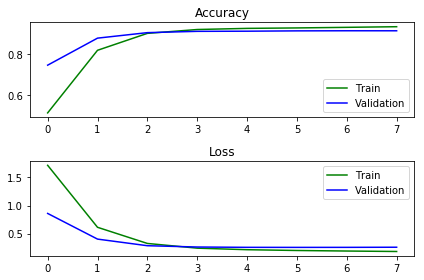

In [74]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| RNN | S_MAX_FEATURES | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 5000 | нет | 0.8867 | 0.8988 | 0.2879 | 0.8608836574547934 |
| **2 модель** | 15000 | 8 | 0.9037 | 0.9159 | 0.2556 | 0.8806721255544182 |
| **3 модель** | 30000 | 7 | 0.9019 | 0.9124 | 0.2648 | 0.879136813374275 | 

заметки:
- чем больше токенов мы подаем в модель, тем быстрее происходит переобучение, т.к. увеличивается кол-во параметров в модели
- лучше всех показала себя модель с 15000 токенами: у нее лучшие показатели по всем параметрам. Это довольно интересно, учитывая, что мы подаем где-то половину всех токенов тренировочного корпуса. Возможно, сыграло роль то, что во всех трех случаях в модель подавались случайно сформированные тренировочная и валидационная выборки (был установлен random_state=42)
- в принципе точность без паддингов не сильно отличается. Это можно объяснить тем, что первые токены имеют самую большую частотность в тренировочной корпусе, которые, возможно, также часто встречались в тестовом корпусе. Следовательно, модель можно было не слишком сильно напрягать количеством токенов)

## Итоги по одинаковым размерам эмбеддинга
### Embedding 64

| модель | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------|-----------------------|----------|-----------|------------------|
| **SimpleRNN** | 7 | 0.9019 | 0.9124 | 0.2648 | 0.879136813374275 |
| **LSTM** | 7 | 0.9005 | 0.9127 | 0.2711 | 0.8760661890139883 |
| **biLSTM** | 7 | 0.9158 | 0.9252 | 0.2366 | 0.8964517229614464 |
| **GRU** | нет | 0.9047 | 0.9128 | 0.2786 | 0.8812691914022519 |

заметки:
- не переобучивается только GRU 
- лучшие показатели у двунаправленной LSTM: это можно объяснить тем, что она сложнее, учитывает больше вещей, чем все остальные сетки  (в принципе двунаправленная сетка чуть больше параметров принимает)
- остальные сетки в принципе сработали нормально, учитывая, что разница в показателях заключается только в долях тысячных, поэтому худшую модель особо не выделишь. У LSTM хуже показатели на тестовой точности и точности без паддингов, у SimpleRNN ненамного хуже показатели по валидационной точности, у GRU хуже показатели по потерям на валидации.

### Embedding 100

| модель | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------|-----------------------|----------|-----------|------------------|
| **SimpleRNN** | 8 | 0.9078 | 0.9147 | 0.2731 | 0.8851074718526101 |
| **LSTM** | 6 | 0.9017 | 0.9120 | 0.2744 | 0.8784544524053224 |
| **biLSTM** | 7 | 0.9172 | 0.9267 | 0.2322 | 0.8978164448993519 |
| **GRU** | 6 | 0.9049 | 0.9135 | 0.2656 | 0.8826339133401568 |

заметки:
- при большей размерности эмбеддинга происходит немного другая картина. GRU и LSTM переобучиваются раньше остальных
-  хуже всех показала себя LSTM: у нее худшие показатели по всем параметрам.
- лучшие показатели у двунаправленной LSTM: это можно объяснить тем, что она сложнее, учитывает больше вещей, чем все остальные сетки  (в принципе двунаправленная сетка чуть больше параметров принимает)
- в принципе показатели по моделям не сильно отличаются.

### Embedding 200

| модель | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------|-----------------------|----------|-----------|------------------|
| **SimpleRNN** | 5 | 0.9073 | 0.9141 | 0.2646 | 0.8853633572159674 | 
| **LSTM** | 6 | 0.901 | 0.9138 | 0.2676 | 0.876919140225179 | 
| **biLSTM** | 6 | 0.9136 | 0.9273 | 0.2296 | 0.8935516888433982 | 
| **GRU** | 6 | 0.9044 | 0.9142 | 0.2615 | 0.881525076765089 | 

заметки:
- теперь все сетки переобучаются на 5 или 6 эпохе.
- лучше всех работает двунаправленная LSTM, т.к. она в принципе сложнее остальных сеток.
- худшие показатели у LSTM, хотя ее показатели не особо отличаются от SimpleRNN и GRU

### Двунаправленная LSTM WINS
- все остальные чуть похуже работают, но тоже нормальные результаты показывают
- при увеличении эмбеддинга модели быстрее переобучиваются
- точность без паддингов не сильно отличается от тестовой и валидационной точностей, т.к.в тестовом корпусе часто встречались известные слова
- чем сложнее модель и сама сетка, которую мы используем, тем лучше показатели
- результаты работы сеток довольно сильно зависит от языкового корпуса, который мы используем
# THE END